In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rulevetting.api.viz as viz
from rulevetting.projects.iai_pecarn.dataset import Dataset

outcome_def = 'outcome'  # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import rulevetting
import os
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

print(f'{"DATA_PATH:":>15}', rulevetting.DATA_PATH)
print(f'{"REPO_PATH:":>15}', rulevetting.REPO_PATH)
print(f'{"MRULES_PATH:":>15}', rulevetting.MRULES_PATH)
print(f'{"PROJECTS_PATH:":>15}', rulevetting.PROJECTS_PATH)

     DATA_PATH: /Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/rule-vetting/data
     REPO_PATH: /Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/rule-vetting
   MRULES_PATH: /Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/rule-vetting/rulevetting
 PROJECTS_PATH: /Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/rule-vetting/rulevetting/projects


# Briefly check data

In [3]:
data_path: str = rulevetting.DATA_PATH
raw_data_path = oj(data_path, "csi_pecarn", 'raw')

fnames = sorted([
    fname for fname in os.listdir(raw_data_path)
    if 'csv' in fname
    #   and not 'radiology' in fname
    #   and not 'kappa' in fname
    ])  # remove outcome (SH: not yet)

r = {}
print('read all the csvs...', fnames)
if len(fnames) == 0:
    print('no csvs found in path', raw_data_path)
for fname in tqdm(fnames):
    df = pd.read_csv(oj(raw_data_path, fname), encoding="ISO-8859-1")
    df.rename(columns={'site': 'SiteID'}, inplace=True)
    df.rename(columns={'SITE': 'SiteID'}, inplace=True)
    df.rename(columns={'caseid': 'CaseID'}, inplace=True)
    df.rename(columns={'controltype': 'ControlType'}, inplace=True)
    df.rename(columns={'studysubjectid': 'SubjectID'}, inplace=True)
    df.rename(columns={'StudySubjectID': 'SubjectID'}, inplace=True)
    assert ('SiteID' in df.keys())
    assert ('CaseID' in df.keys())
    assert ('ControlType' in df.keys())
    assert ('SubjectID' in df.keys())
    r[fname] = df

read all the csvs... ['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']


100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.28it/s]


In [4]:
print(r.keys())
for fname in fnames:
    df = r[fname]
    print(f'{fname:>35}', df.shape)

dict_keys(['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv'])
              analysisvariables.csv (3314, 36)
      clinicalpresentationfield.csv (3314, 101)
    clinicalpresentationoutside.csv (3314, 114)
       clinicalpresentationsite.csv (3314, 136)
                   demographics.csv (3314, 11)
           injuryclassification.csv (540, 208)
                injurymechanism.csv (3314, 35)
                          kappa.csv (365, 124)
                 medicalhistory.csv (3314, 32)
               radiologyoutside.csv (3314, 16)
                radiologyreview.csv (445, 16)
                  radiologysite.csv (3314, 15)


injuryclassfication / kappa / radiologyreview : less rows than others

In [5]:
print("Check unique SubjectID for each .csv")
a = 0
for fname in fnames:
    df = r[fname]
    if df.shape[0] != len(pd.unique(df.SubjectID)):
        a += 1
        print(fname)
if(a==0):
    print("ALL .csv file has unique SubjectID")

Check unique SubjectID for each .csv
ALL .csv file has unique SubjectID


In [6]:
fnames_small = [fname for fname in fnames
                if not 'radiology' in fname
                    and not 'kappa' in fname
                    and not 'injuryclassification' in fname
                    and not 'outside' in fname
                    and not 'onfield' in fname]
print(fnames_small)

cols = 0
rows = 0

df_features = r[fnames_small[0]]
print('merge all the dfs...')
for i, fname in tqdm(enumerate(fnames_small)):
    df2 = r[fname].copy()
    # if subj has multiple entries, only keep first
    df2 = df2.drop_duplicates(subset=['SubjectID'], keep='last')
    # don't save duplicate columns
    df_features = df_features.set_index('SubjectID').combine_first(df2.set_index('SubjectID')).reset_index()
    # SH: check the number ofcolumns
    rows += df2.shape[0]
    cols += df2.shape[1]

['analysisvariables.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injurymechanism.csv', 'medicalhistory.csv']
merge all the dfs...


5it [00:00, 15.18it/s]


In [7]:
print(rows, cols)
print(len(df_features.columns))
print(len(pd.unique(df_features.columns)))
print(df_features.shape)

16570 250
234
234
(3314, 234)


The difference between `cols` and `df_features.shape[1]` = 4 * (`len(fnames_small)`-1) 
(because of `SiteID`, `CaseID`, `ControlType`, `SubjectID`)

In [8]:
# SH: NO outcomes yet
# df_outcomes = helper.get_outcomes(raw_data_path)

In [9]:
df = df_features # SH: not working - some variables must be constant
#df = r[fnames[0]]
processed_feats = df.keys().values.tolist()
print(len(processed_feats))

234


In [10]:
temp = df.var(axis = 0, skipna = True, numeric_only = True) == 0
const_var = []
for i in temp.index:
    if temp[i]:
#        print(i)
        const_var.append(i)
print(const_var)

['BodyAsAWhole1', 'BodyAsAWhole4', 'Endocrinological1', 'Genitourinary1', 'HematologicLymphatic2']


In [11]:
df[const_var]

,BodyAsAWhole1,BodyAsAWhole4,Endocrinological1,Genitourinary1,HematologicLymphatic2
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
3309,0,0,0,0,0
3310,0,0,0,0,0
3311,0,0,0,0,0
3312,0,0,0,0,0


In [12]:
print(df["ControlType"].unique())
df = df.assign(outcome=lambda x: (x.ControlType == 'case').astype(int))
df.drop(columns = "ControlType")

['case' 'ems' 'moi' 'ran']


,SubjectID,AVPU,AVPUDetails,AVPUMental,AVPUMentaltxt,AVPUMentaltxtCat,AgeInYears,AlteredMentalStatus,AlteredMentalStatus2,ArrPtIntub,...,ambulatory,axialloadtop,clotheslining,helmet,injurydate,subinj_Ext2,subinj_Face2,subinj_Head2,subinj_TorsoTrunk2,outcome
0,110001,Y,U,NaN,NaN,NaN,15.71,1.0,1.0,Y,...,0.0,0,NaN,NaN,1/1/2000,0.0,0.0,1.0,1.0,1
1,110002,Y,A,NaN,NaN,NaN,15.94,0.0,0.0,N,...,0.0,0,N,N,1/1/2000,0.0,0.0,0.0,0.0,1
2,110003,Y,A,NaN,NaN,NaN,14.53,0.0,0.0,N,...,NaN,1,NaN,NaN,1/1/2000,0.0,0.0,0.0,0.0,1
3,110004,Y,A,NaN,NaN,NaN,14.96,0.0,0.0,N,...,1.0,1,N,Y,12/28/1999,0.0,0.0,0.0,0.0,1
4,110005,N,NaN,NaN,NaN,NaN,13.23,NaN,NaN,N,...,NaN,0,N,ND,12/30/1999,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,1743310,Y,A,NaN,NaN,NaN,2.97,0.0,0.0,N,...,NaN,0,NaN,NaN,1/1/2000,1.0,0.0,0.0,0.0,0
3310,1743311,Y,A,NaN,NaN,NaN,12.82,0.0,0.0,N,...,0.0,0,N,Y,1/1/2000,0.0,0.0,0.0,0.0,0
3311,1743312,Y,A,NaN,NaN,NaN,0.82,0.0,0.0,N,...,0.0,0,NaN,NaN,1/1/2000,0.0,0.0,0.0,0.0,0
3312,1743313,Y,A,NaN,NaN,NaN,0.11,0.0,0.0,N,...,0.0,0,NaN,NaN,1/1/2000,0.0,0.0,1.0,0.0,0


In [14]:
#print(df.dtypes)
dc = {}
for t in df.dtypes:
    if t in dc.keys():
        dc[t] = dc[t] +1
    else:
        dc[t] = 1
print(dc)

{dtype('int64'): 102, dtype('O'): 85, dtype('float64'): 48}


There is no Boolean column

In [15]:
valids = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=valids)

In [16]:
newdf

,SubjectID,AgeInYears,AlteredMentalStatus,AlteredMentalStatus2,ArrivalTimeND,Assault,AxialLoadAnyDoc,BodyAsAWhole0,BodyAsAWhole1,BodyAsAWhole2,...,Torticollis2,TotalGCSManual,VerbalGCS,ambulatory,axialloadtop,subinj_Ext2,subinj_Face2,subinj_Head2,subinj_TorsoTrunk2,outcome
0,110001,15.71,1.0,1.0,0,NaN,0,0,0,0,...,0.0,NaN,1.0,0.0,0,0.0,0.0,1.0,1.0,1
1,110002,15.94,0.0,0.0,0,NaN,0,0,0,0,...,0.0,NaN,5.0,0.0,0,0.0,0.0,0.0,0.0,1
2,110003,14.53,0.0,0.0,0,NaN,1,0,0,0,...,1.0,NaN,5.0,NaN,1,0.0,0.0,0.0,0.0,1
3,110004,14.96,0.0,0.0,0,NaN,1,0,0,0,...,0.0,NaN,NaN,1.0,1,0.0,0.0,0.0,0.0,1
4,110005,13.23,NaN,NaN,1,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,1743310,2.97,0.0,0.0,0,NaN,0,0,0,0,...,0.0,NaN,5.0,NaN,0,1.0,0.0,0.0,0.0,0
3310,1743311,12.82,0.0,0.0,0,NaN,0,0,0,0,...,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0,0
3311,1743312,0.82,0.0,0.0,0,NaN,0,0,0,0,...,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0,0
3312,1743313,0.11,0.0,0.0,0,NaN,1,0,0,0,...,NaN,NaN,NaN,0.0,0,0.0,0.0,1.0,0.0,0


In [17]:
nonconst_var = np.setdiff1d(np.asarray(newdf.columns), const_var)
print(len(np.asarray(newdf.columns)))
print(len(const_var))
print(len(nonconst_var))
newdf = newdf[nonconst_var]

150
5
145


In [18]:
# pandas impute missing values with median
newdf = newdf.fillna(df.median(numeric_only = True))
print(len(newdf.columns))

145


In [19]:
#corrs = df[processed_feats].corr(method='pearson')
corrs = newdf[nonconst_var].corr(method='pearson')
print(corrs.shape)
#print(corrs)

(145, 145)


In [172]:
corrs.isna().sum().sum()

0

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


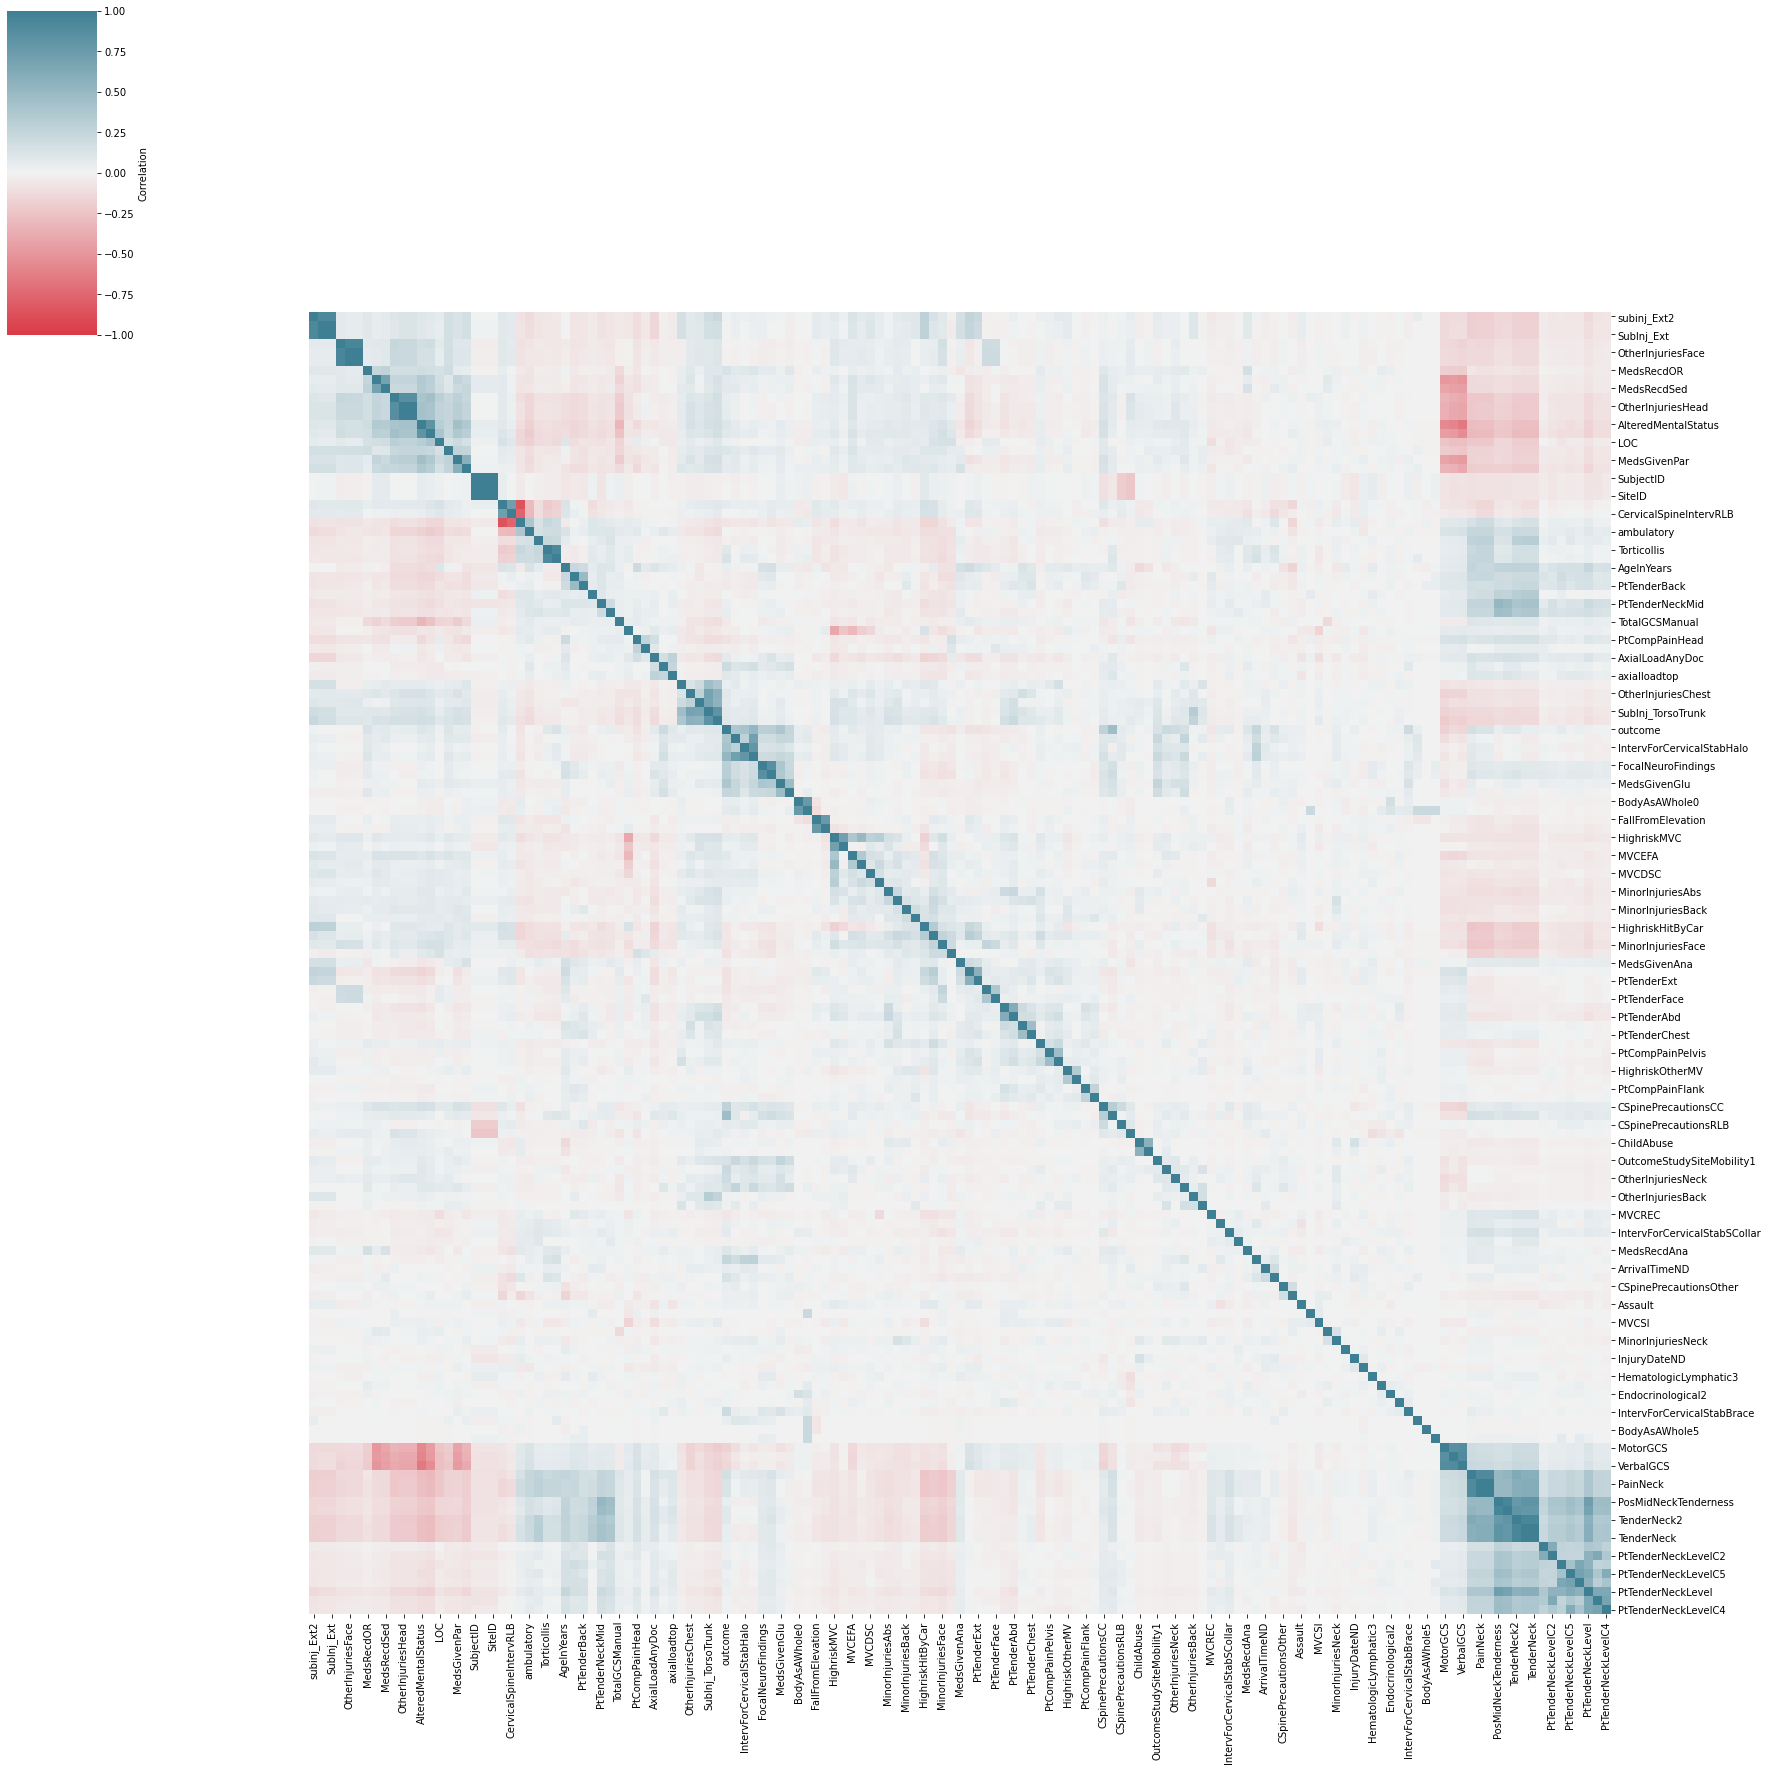

In [20]:
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'},
#                         yticklabels=True,
                         figsize=(25, 25))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

## Here is the end of SH progress (11/20/2021)
***

# get data

In [103]:
df_train, df_tune, _ = Dataset().get_data(load_csvs=True)
df = df_train
processed_feats = df.keys().values.tolist()
print(processed_feats)
print(len(processed_feats))

['AbdDistention_no', 'AbdDistention_or_AbdomenPain_no', 'AbdDistention_or_AbdomenPain_yes', 'AbdDistention_unknown', 'AbdDistention_yes', 'AbdTenderDegree_Mild', 'AbdTenderDegree_Moderate', 'AbdTenderDegree_None', 'AbdTenderDegree_Severe', 'AbdTenderDegree_unknown', 'AbdTrauma_no', 'AbdTrauma_or_SeatBeltSign_no', 'AbdTrauma_or_SeatBeltSign_yes', 'AbdTrauma_unknown', 'AbdTrauma_yes', 'AbdomenPain_no', 'AbdomenPain_unknown', 'AbdomenPain_yes', 'Age', 'Age<2_no', 'Age<2_yes', 'CostalTender_no', 'CostalTender_yes', 'DecrBreathSound_no', 'DecrBreathSound_unknown', 'DecrBreathSound_yes', 'DistractingPain_no', 'DistractingPain_unknown', 'DistractingPain_yes', 'GCSScore', 'GCSScore_Full_no', 'GCSScore_Full_yes', 'Hypotension_no', 'Hypotension_yes', 'LtCostalTender', 'MOI_Bike collision/fall', 'MOI_Fall down stairs', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle

**correlations between features**

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

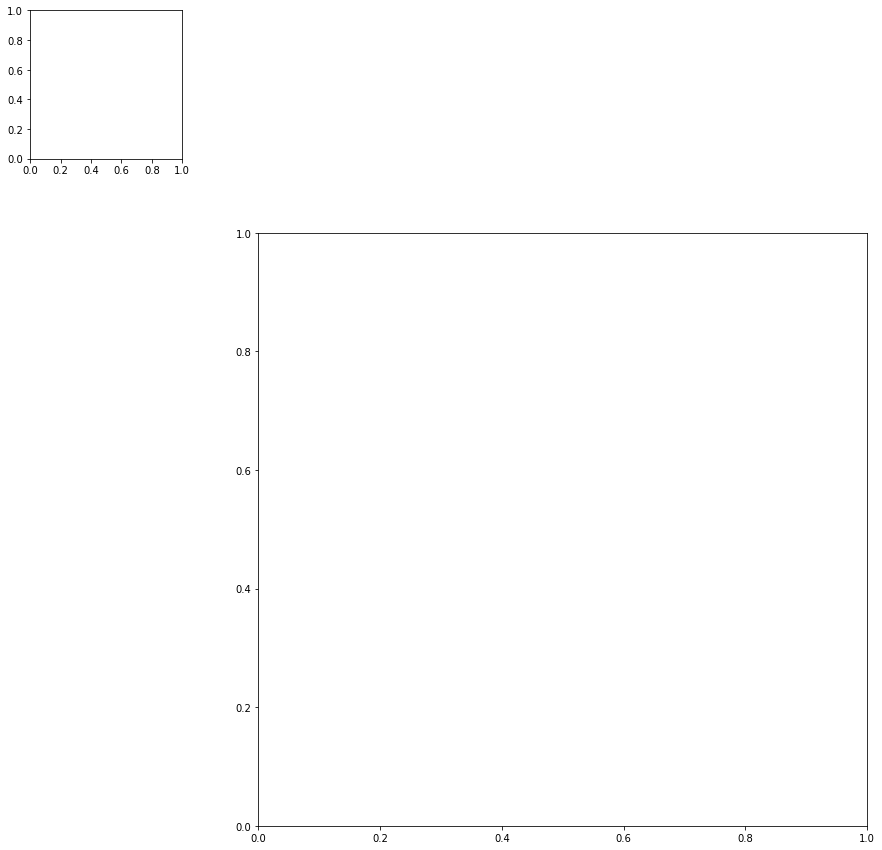

In [102]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats].corr(method='pearson')
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'},
                         yticklabels=True,
                         figsize=(15, 15))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

plt.show()
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

**individual correlations with outcome**

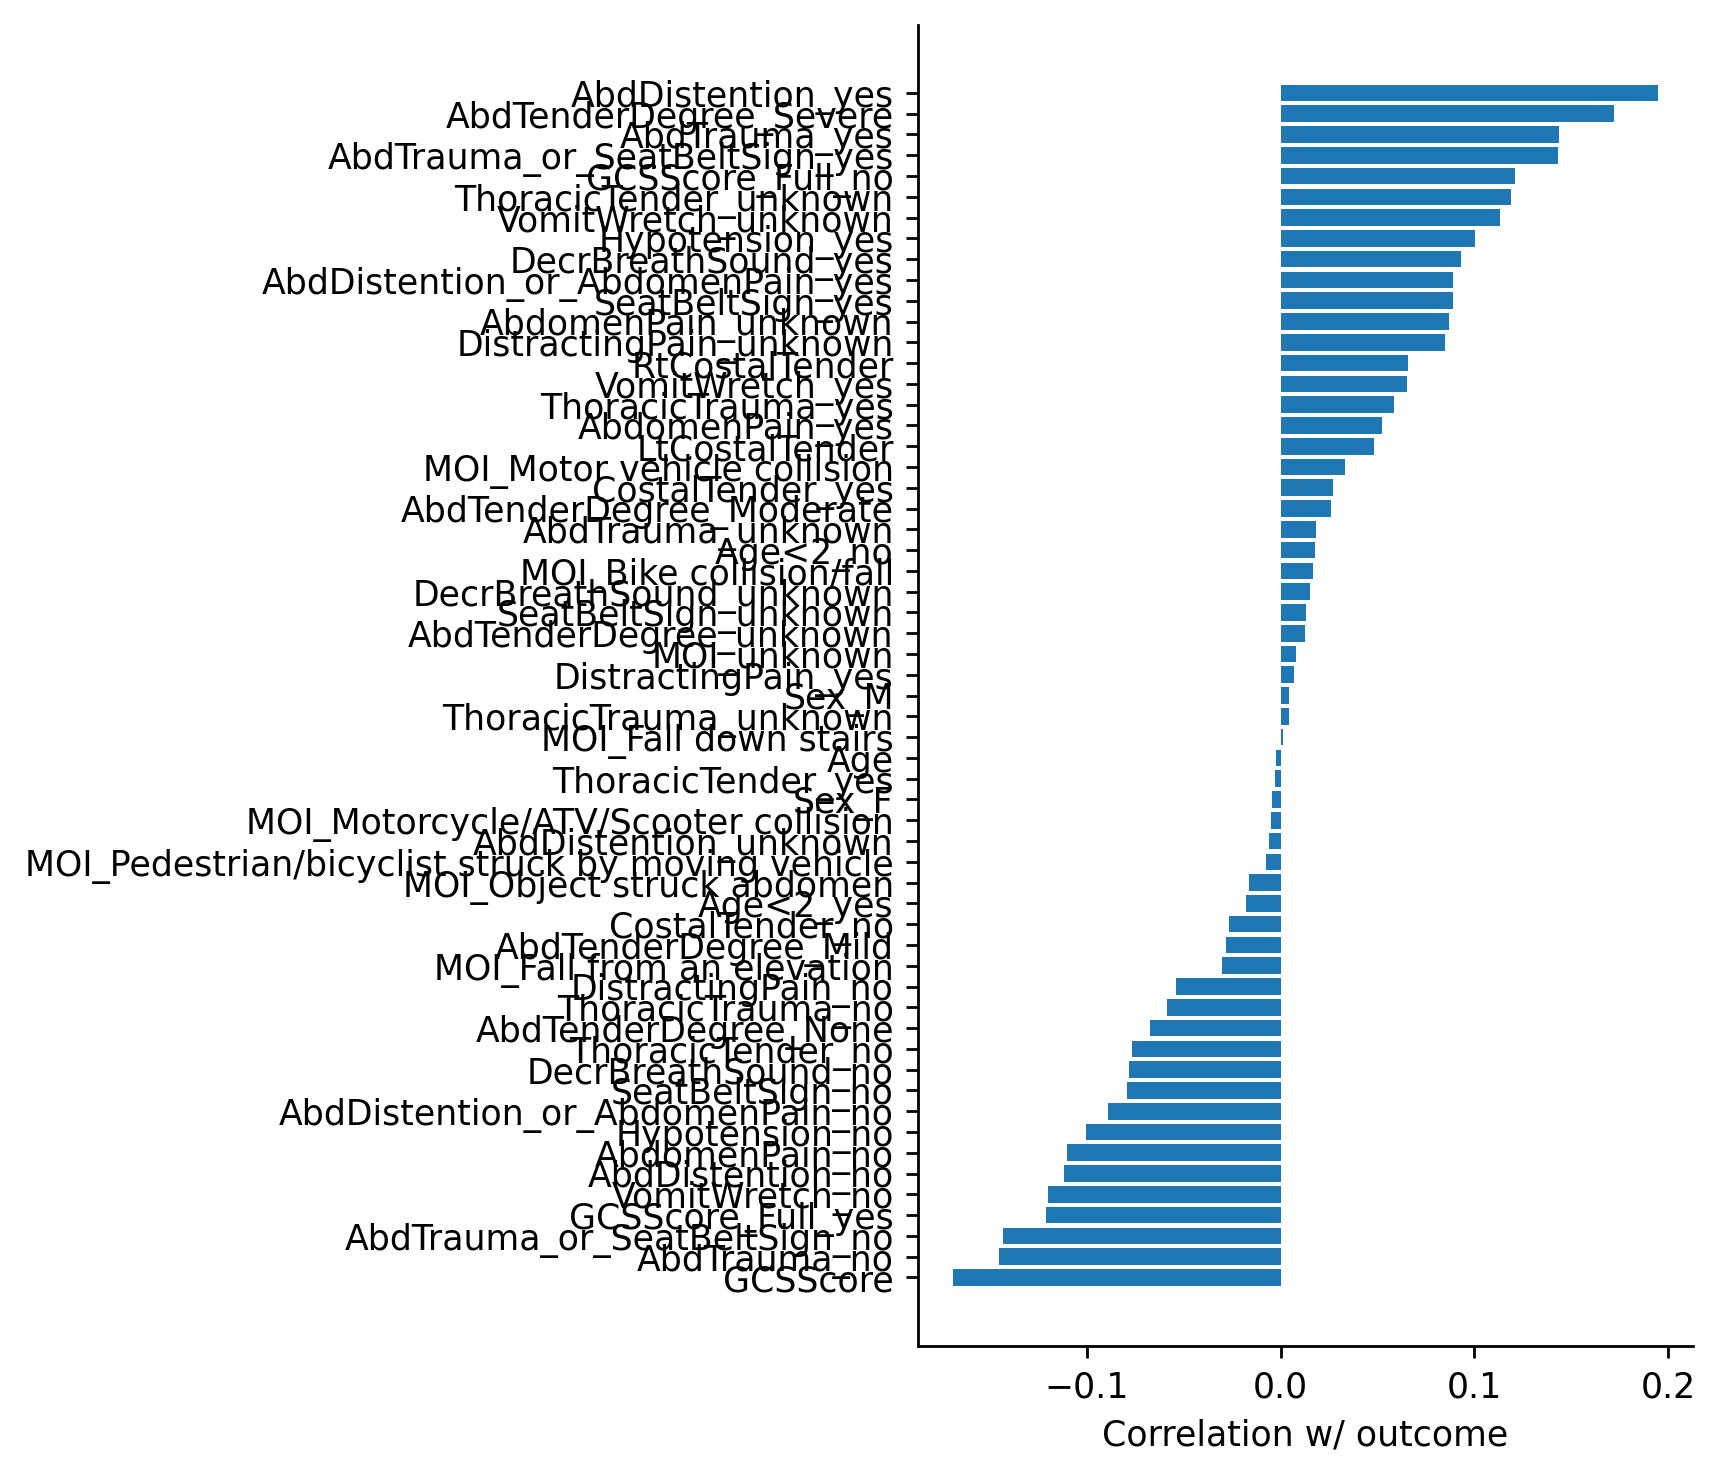

In [4]:
plt.figure(dpi=250, figsize=(4, 7))
vals = corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

**subgroup risks (with sizes)**

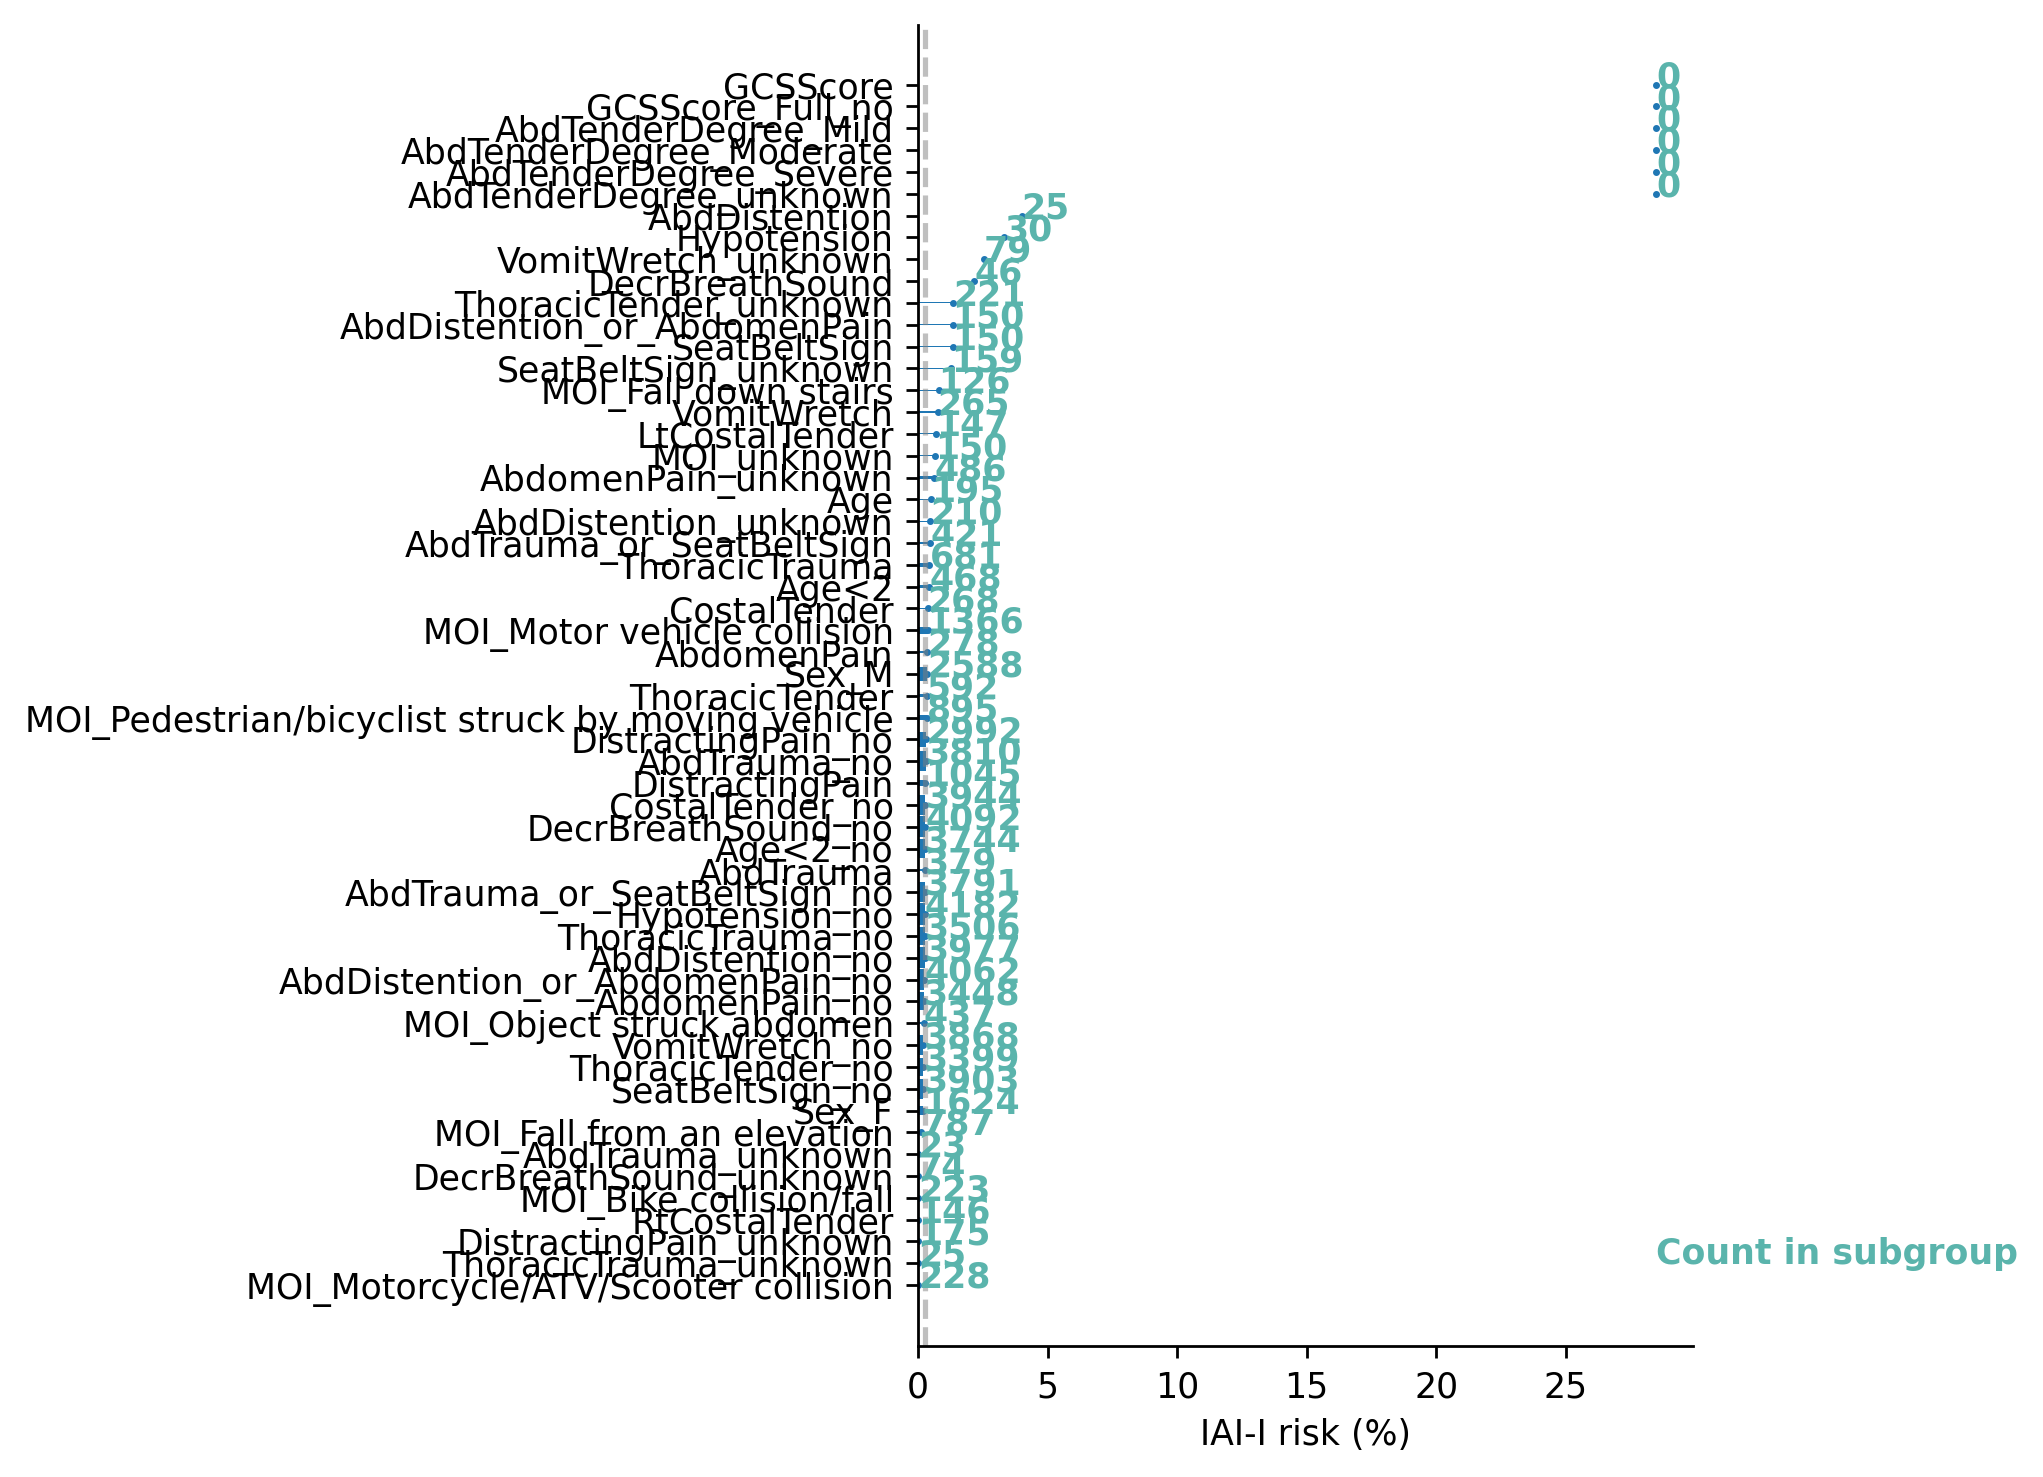

In [5]:
def plot_subgroup_risks(df, head=None, tail=None):
    plt.figure(dpi=250, figsize=(4, 7))
    ks = np.array([k for k in df.keys()
                   if not k == outcome_def])
    mean_risk_baseline = df[outcome_def].mean() * 100
    if head is not None or tail is not None:
        ks = np.array([k for k in ks
                       if np.sum(df[k]) >= 10
                       and np.abs(np.mean(df[k]) - mean_risk_baseline) > 1
                       and not np.sum([df[k] == 1]) == 0])  # should have at least one IAI-I
    vals = np.array([np.mean(df[outcome_def][df[k] == 1]) for k in ks])
    vals[np.isnan(vals)] = mean_risk_baseline
    counts = np.array([np.sum([df[k] == 1]) for k in ks])
    args = np.argsort(vals)
    if head is not None:
        args = args[:head]
    if tail is not None:
        args = args[-tail:]
    labs = ks[args]
    vals = vals[args] * 100
    counts = counts[args]
    counts_norm = counts / np.nanmax(counts)
    ax = plt.subplot(111)
    plt.plot(vals, np.arange(vals.size), 'o', ms=1)
    plt.barh(y=np.arange(vals.size), width=vals, height=1.0 * counts_norm)
    plt.yticks(np.arange(vals.size), [lab.replace('_yes', '') for lab in labs])
    for i, (v, c) in enumerate(zip(vals, counts)):
        ax.text(v, i - 0.1, str(c), color=viz.cg, fontweight='bold')
    plt.axvline(mean_risk_baseline, color='gray', linestyle='--', alpha=0.5)
    ax.text(vals.max(), 1, 'Count in subgroup', color=viz.cg, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('IAI-I risk (%)')
    plt.show()


# plot_subgroup_risks(df[processed_feats + [outcome_def]])
# dd = df[(df['AbdTenderDegree_None']==1) & (df['GCSScore_Full_yes'] == 1)] # low-risk group left to split
# plot_subgroup_risks(dd[[k for k in processed_feats if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']] + [outcome_def]])
dd = df[(df['AbdTenderDegree_None'] == 1) & (
            df['GCSScore_Full_yes'] == 1)]  # & (df['DecrBreathSound_yes'] == 0)] # low-risk group left to split
plot_subgroup_risks(dd[[k for k in processed_feats
                        if not k in ['AbdTenderDegree_None', 'GCSScore_Full_yes']]])

**joint correlations (or risks) with outcome joint**

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


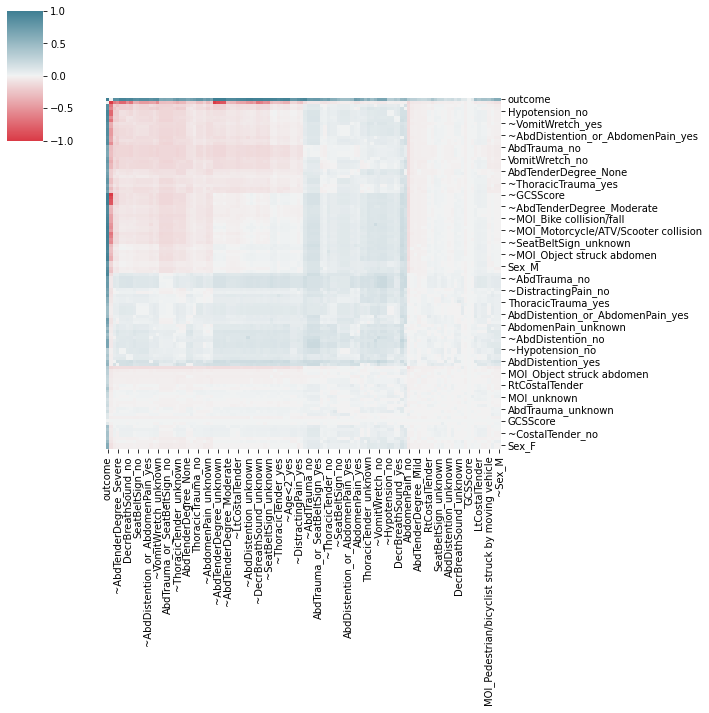

In [6]:
func = lambda x, y: np.corrcoef(x, y)[0, 1]  # corr
# func = lambda x, y: np.mean(y[x]) # frac high-risk
d = len(processed_feats)
mat = np.zeros((2 * d, 2 * d))
y = df[outcome_def]
for r in range(d):
    for c in range(d):
        xr = df[processed_feats[r]] == 1
        xc = df[processed_feats[c]] == 1
        mat[2 * r, 2 * c] = func(xr & xc, y)
        mat[2 * r + 1, 2 * c] = func(~xr & xc, y)
        mat[2 * r, 2 * c + 1] = func(xr & ~xc, y)
        mat[2 * r + 1, 2 * c + 1] = func(~xr & ~xc, y)

fs = np.array([[x, '~' + x] for x in processed_feats]).flatten()
mat[np.isnan(mat)] = 0
matt = pd.DataFrame(mat, index=fs, columns=fs)
vabs = np.max([np.abs(np.min(mat)), np.max(mat)])
vmin = -vabs
cmap = viz.cmap_div
if np.min(mat) >= 0:
    vmin = 0
    cmap = 'Blues'
corrmap = sns.clustermap(matt, cmap=cmap, vmin=vmin, vmax=vabs,
                         dendrogram_ratio=0.2, figsize=(10, 10), )
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
#                row_cluster=False, col_cluster=False)
# plt.savefig('dendrogram.png', dpi=400)
# plt.tight_layout()
plt.show()

# features scatter plots

## continuous features

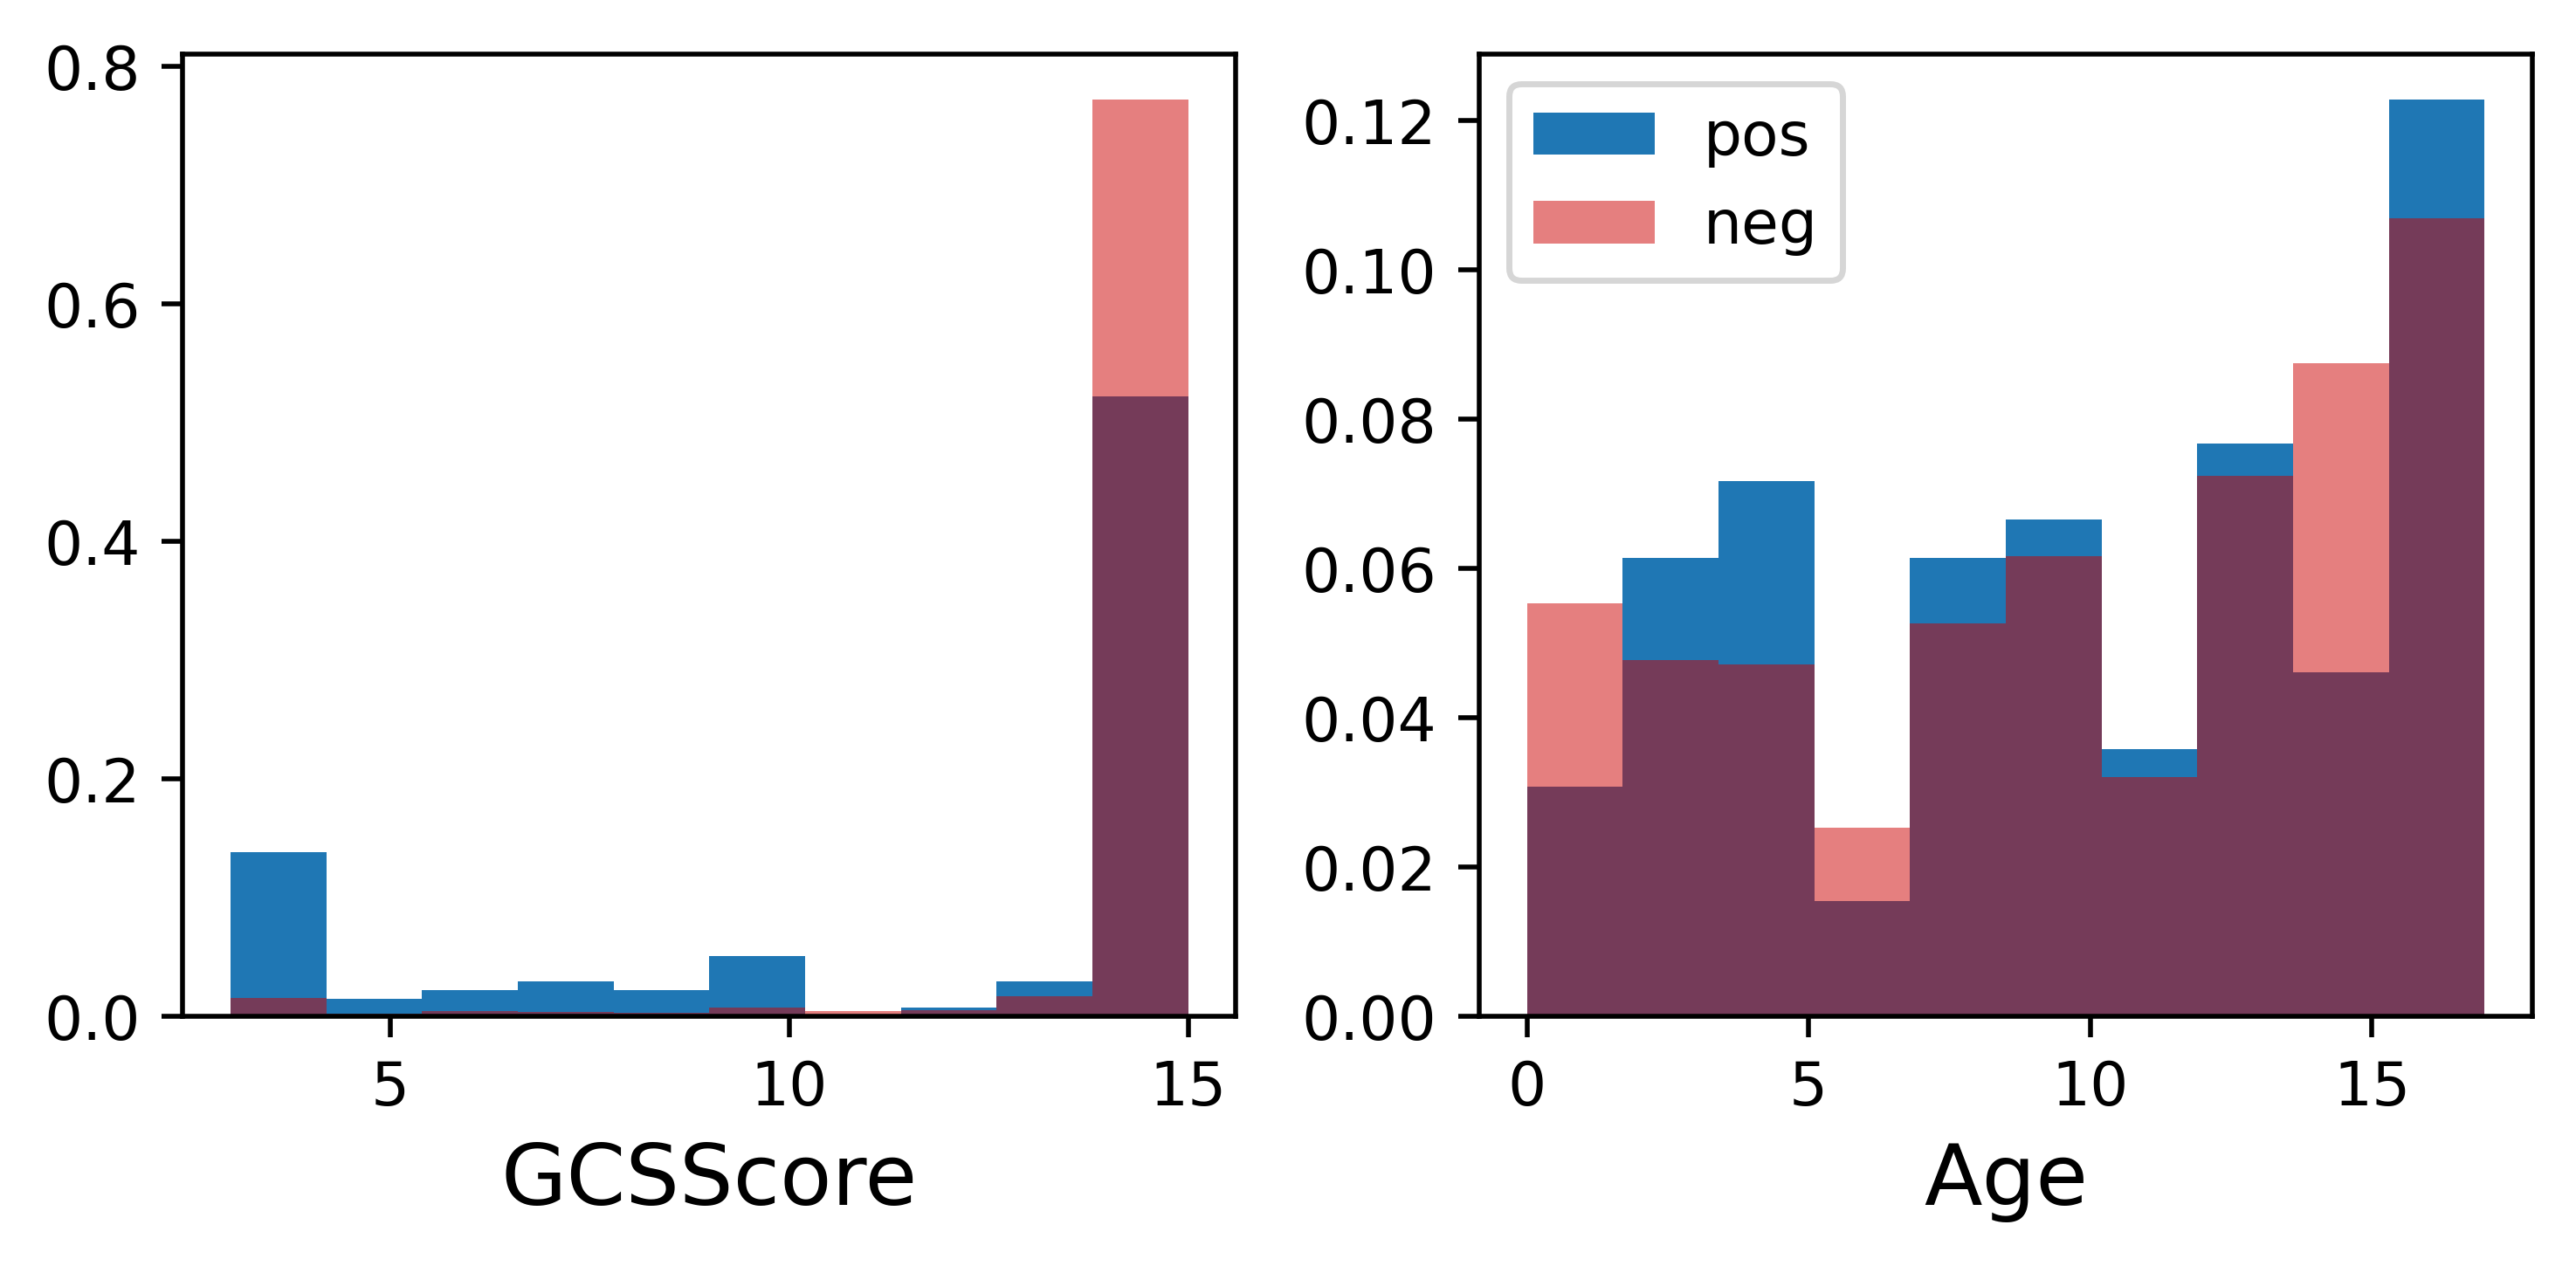

In [7]:
feats_numerical = ['GCSScore', 'Age']
# feats_categorical = ['AbdTenderDegree', 'Race', 'MOI']
R, C, = 1, 2
plt.figure(figsize=(6, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=viz.cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=viz.cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [8]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14., 15.]), array([18,  1,  2,  3,  4,  3,  3,  4,  1,  4,  9, 63]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 119,   13,   16,   36,   31,   23,   35,   27,   37,   41,  145,
        372, 6216]))


## scatter plots

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributio

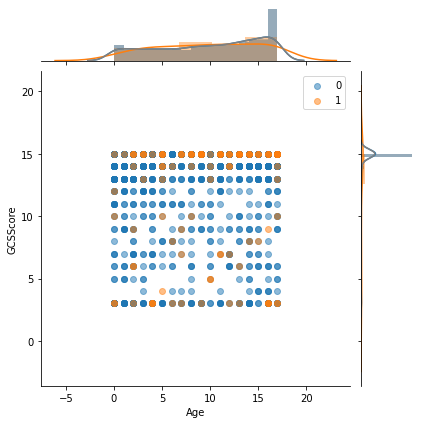

In [9]:
viz.jointplot_grouped('Age', 'GCSScore', 'outcome', df)

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/sh-trial/trial-env/lib/python3.8/site-packages/seaborn/distributio

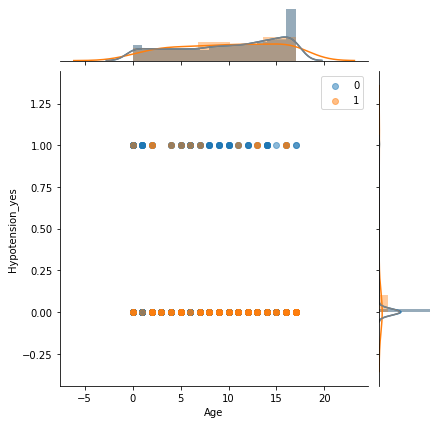

In [10]:
viz.jointplot_grouped('Age', 'Hypotension_yes', 'outcome', df)